# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [2]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

from sklearn.model_selection import train_test_split

In [3]:
#read in df_new and df2
df_new = pd.read_pickle('D:/CUNY Files/capstone/code files/2014_LA_SH_by_vessel.pkl')
df2 = pd.read_pickle('D:/CUNY Files/capstone/code files/2014_LA_SH_Summary_V2.pkl')

In [4]:
df_new.head()

,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days_sum,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum_sum,shipment_count_sum
0,9294800,5,2,25,1,1,1,1,1,1,1
1,9337937,2,1,14,6,1,1,1,11,5718,11
2,9337937,2,2,16,4,1,1,1,1,1141,1
3,9364992,9,1,14,-8,1,1,1,1,3,1
4,9364992,10,2,17,3,2,2,2,2,1136,2


In [5]:
df2.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,day_of_month_est,half_month_est,...,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,5,1,...,3,2,2,1,0,0,0,1,126,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,5,2,2,4,1,1,1,1,1000,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,5,2,2,4,0,0,0,1,2079,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,25,2,...,6,5,5,0,1,1,1,1,14,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,8,1,...,3,5,5,7,1,1,1,14,196,14


In [6]:
#add identifier count to df_new
id_count =df2[['vessel_name','month_est','half_month_est','identifier']].groupby(
    ['vessel_name','month_est','half_month_est']).agg(['count'])

#reformat columns
id_count.columns = ['_'.join(tup).rstrip('_') for tup in id_count.columns.values]
id_count.reset_index(col_level=1,inplace = True)

In [7]:
id_count.head()

,vessel_name,month_est,half_month_est,identifier_count
0,9294800,5,2,1
1,9337937,2,1,2
2,9337937,2,2,1
3,9364992,9,1,1
4,9364992,10,2,2


In [8]:
id_count.shape

(1900, 4)

In [9]:
#add id count
df_new = df_new.merge(id_count, on = ['vessel_name','month_est','half_month_est'], how = 'left')

In [10]:
df_new.shape

(1900, 12)

In [11]:
df_new.head()

,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days_sum,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum_sum,shipment_count_sum,identifier_count
0,9294800,5,2,25,1,1,1,1,1,1,1,1
1,9337937,2,1,14,6,1,1,1,11,5718,11,2
2,9337937,2,2,16,4,1,1,1,1,1141,1,1
3,9364992,9,1,14,-8,1,1,1,1,3,1,1
4,9364992,10,2,17,3,2,2,2,2,1136,2,2


In [72]:
#change the column name of the delay days
df_new.rename(columns = {'delay_days_sum':'delay_days','piece_count_sum_sum':'piece_count_sum',
                         'shipment_count_sum':'shipment_count'}, inplace=True)

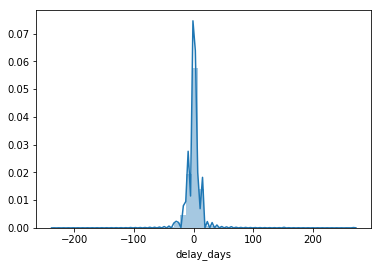

In [14]:
#plot the distribution of ship delays
sns.distplot(df_new.delay_days)

The outliers still remain after weighting by number of observations

Text(0,0.5,'delay days')

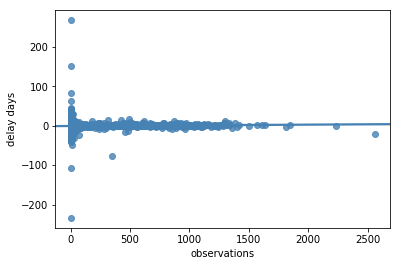

In [15]:
#look at scatter between number of observations for the vessel and delay days
ax = sns.regplot(x="identifier_count", y="delay_days", data=df_new, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('observations')
ax.set_ylabel('delay days')

Outliers occur mostly when there are fewer numbers of observations, view just observations that are less than 500

Text(0,0.5,'delay days')

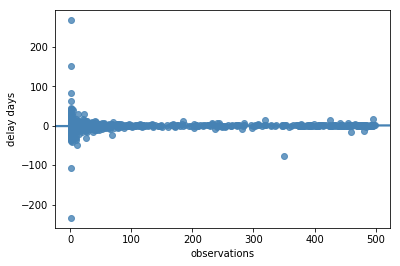

In [16]:
#look at less than 500 observations
ax = sns.regplot(x="identifier_count", y="delay_days", data=df_new[df_new.identifier_count < 500], color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('observations')
ax.set_ylabel('delay days')

Text(0,0.5,'delay days')

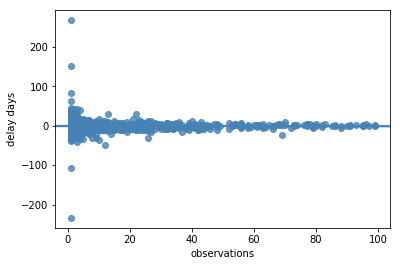

In [17]:
#look at scatter between
ax = sns.regplot(x="identifier_count", y="delay_days", data=df_new[df_new.identifier_count < 100], color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('observations')
ax.set_ylabel('delay days')

Text(0,0.5,'delay days')

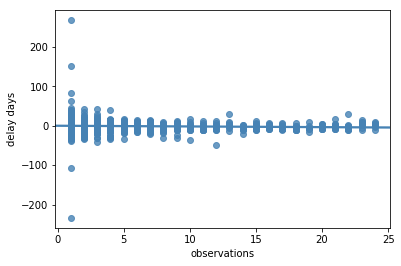

In [18]:
#look at scatter between
ax = sns.regplot(x="identifier_count", y="delay_days", data=df_new[df_new.identifier_count < 25], color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('observations')
ax.set_ylabel('delay days')

Text(0,0.5,'delay days')

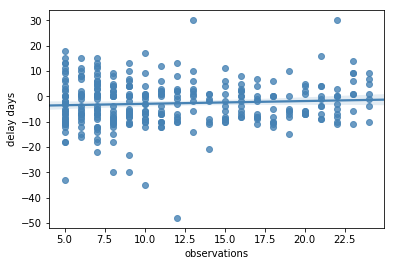

In [19]:
#look at scatter between 1 and 25
ax = sns.regplot(x="identifier_count", y="delay_days", data=df_new[(df_new.identifier_count >= 5)
                                                                  & (df_new.identifier_count < 25)], color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('observations')
ax.set_ylabel('delay days')

Text(0,0.5,'delay days')

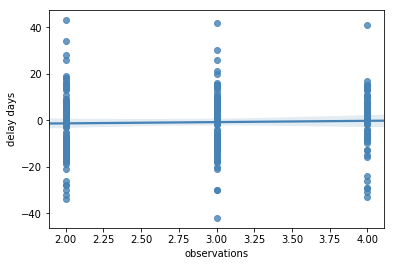

In [20]:
#look at scatter between 1 and 5
ax = sns.regplot(x="identifier_count", y="delay_days", data=df_new[(df_new.identifier_count > 1)
                                                                  & (df_new.identifier_count < 5)], color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('observations')
ax.set_ylabel('delay days')

Text(0,0.5,'delay days')

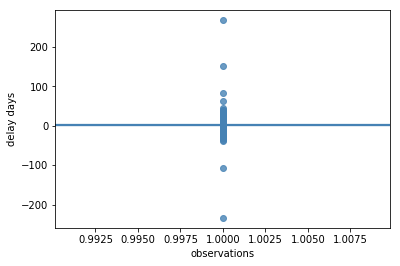

In [21]:
#look at scatter between 1 and 5
ax = sns.regplot(x="identifier_count", y="delay_days", data=df_new[df_new.identifier_count == 1], color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('observations')
ax.set_ylabel('delay days')

The most extreme delays occur when there is only one observation per vessel, and gets tighter with more observations implying that these are likely errors in the data.

In [22]:
#get number of vessels with only 1 observation, then fewer than 5 observations
round(len(df_new[df_new.identifier_count == 1])/ (len(df_new) * 1.0), 4)

0.2353

In [57]:
round(len(df_new[df_new.identifier_count < 5])/ (len(df_new) * 1.0), 4)

0.4063

In [105]:
df_new.head()

,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count,identifier_count
0,9294800,5,2,25,1,1,1,1,1,1,1,1
1,9337937,2,1,14,6,1,1,1,11,5718,11,2
2,9337937,2,2,16,4,1,1,1,1,1141,1,1
3,9364992,9,1,14,-8,1,1,1,1,3,1,1
4,9364992,10,2,17,3,2,2,2,2,1136,2,2


Text(0.5,1,'delay days distribution by month')

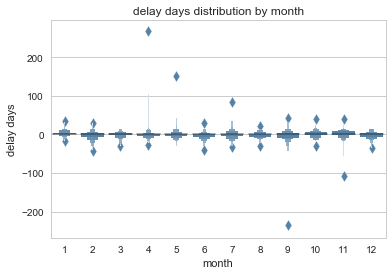

In [117]:
#view the distribution of delay days by ship by month
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_est", y="delay_days", data=df_new, color = 'steelblue')
ax.set_ylabel('delay days')
ax.set_xlabel('month')
ax.set_title('delay days distribution by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

Vessels with fewer than 5 observations (by identifier) are more prone to error and will be dropped from the dataset, this is possible to apply to future datasets so it's a reasonable rule

In [74]:
df_new_5 = df_new[df_new.identifier_count >= 5]
df_new_5.shape

(1128, 12)

In [75]:
df_new_5.head()

,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count,identifier_count
8,9645865,8,2,16,1,2,2,2,6,523,7,7
22,ANTON SCHULTE,8,2,52,-1,382,378,421,708,562886,1224,656
23,ANTON SCHULTE,9,1,4,-9,11,10,10,19,1865,20,14
25,ANTON SCHULTE,10,1,7,1,406,405,446,836,516172,1159,720
26,ANTON SCHULTE,10,2,20,-12,8,8,8,9,5327,10,10


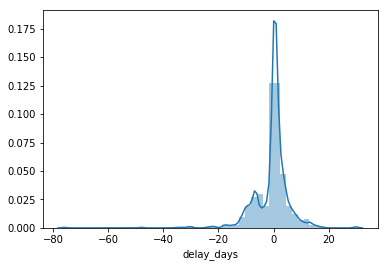

In [63]:
sns.distplot(df_new_5.delay_days)

In [66]:
df_new_5[df_new_5.delay_days <= -20]

,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum_sum,shipment_count_sum,identifier_count,top5_carrier
174,BROOKLYN BRIDGE,9,2,54,-24,50,51,52,45,28576,71,69,0
242,CMA CGM ORFEO,7,1,13,-30,4,4,5,3,436,8,8,1
355,CSCL SPRING,8,1,12,-22,5,5,5,9,8055,9,7,1
366,CSCL SUMMER,9,1,1,-30,4,5,5,4,8984,9,9,1
376,CSCL WINTER,9,1,70,-76,70,84,86,151,438637,642,350,1
377,CSCL WINTER,9,2,32,-35,6,7,7,2,3091,10,10,1
469,HANJIN CHINA,2,1,60,-22,773,823,876,1088,1180701,3262,2563,1
528,HANJIN LONG BEACH,6,2,36,-33,5,5,5,5,873,5,5,1
574,HANJIN NEW YORK,8,1,26,-23,4,4,4,8,2846,10,9,1
642,HYUNDAI NEW YORK,9,1,4,-48,4,4,4,3,2393,12,12,0


** Set up the initial features and look for correlations **

In [42]:
list(df2)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'vessel_name',
 'carrier',
 'port_of_unlading',
 'estimated_arrival_date',
 'day_of_month_est',
 'half_month_est',
 'actual_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'consignee_name_nunique',
 'shipper_party_name_nunique',
 'shipper_consigner_nunique',
 'container_number_nunique',
 'piece_count_sum',
 'shipment_count',
 'top5_carrier']

Determine if either of the following can be turned into features:
- place_of_receipt: evaluate number of different places, can they be categorized by volume?
- carrier: top 5/top 10 by volume (binary variable)

In [43]:
#number of unique places_of_receipt
len(df2.place_of_receipt.unique())

881

In [44]:
#view the list
list(df2.place_of_receipt.unique())

['SHANGHAI',
 'JIANGYIN, CHINA',
 'TAICANG',
 'SHANGHAI, PC',
 'SHANGHAI, CHINA',
 'MUMBAI',
 'HANGZHOU CN',
 'SHANGHAI CN',
 'CHONGQING',
 'SHANGHAI,SH,CN',
 'JIUJIANG',
 'NANJING',
 'SHANGHAI,CHINA,CF',
 'SHANGHAI,CFS',
 'CHANGSHA,DOOR',
 'WUJIANG',
 'ZHANGJIAGANG',
 'NANTONG',
 'YANGZHOU',
 'YANGSHAN, PC',
 'QINGDAO',
 'ANQING',
 'WUHAN, CHINA',
 'ZHANGJIAGANG, CHI',
 'CHANGZHOU',
 'WUHAN',
 'CHONG QING,CHI',
 'CHENNAI (EX MADRA',
 'ICD,DADRI',
 'MUNDRA, INDIA',
 'TUTICORIN, INDIA',
 'NHAVA SHEVA',
 'MANILA, PHILS',
 'WUXI',
 'NINGBO',
 'SUZHOU',
 'NANCHANG',
 'SHANGHAI,CN',
 'HANGZHOU',
 'CNSHA',
 'LIANYUNGANG,CN',
 'ALL OTH PEOPLES R',
 'TAIZHOU CITY CN',
 'WUXI CN',
 'NHAVA SHEVA, INDI',
 'PENANG',
 'MUNDRA',
 'KARACHI',
 'ANKLESHWAR, INDIA',
 'BDCGP',
 'KARACHI, PAKISTAN',
 'DALIAN',
 'WUHAN,HUBEI',
 'DURBAN, ZA',
 'NHAVA SHEVA INDIA',
 'MANILA',
 'SHANGHAI,CHINA',
 'WUHU, CHINA',
 'SHANGHAI.CHINA.',
 'TIANJIN,TJCN',
 'CHENGDU',
 'PUDONG, SHANGHAI',
 'WUHAN, CN',
 'YICHANG, CHIN

The place of receipt list does not have standardized names, and it would be time consuming to use text analysis to standardize, so this will not be used as a feature

In [45]:
#view unique list of carriers.
#Note: the carrier was created from the first word of the ship name which is not always the carrier name
len(df2.carrier.unique())

141

In [46]:
list(df2.carrier.unique())

['HANJIN',
 'CMACGM',
 'CSCL',
 'BALTIMORE',
 'XIN',
 'NYK',
 'APL',
 'MOL',
 'R',
 'KOTA',
 'OOCL',
 'MSC',
 'BAI',
 'COSCO',
 'MANULANI',
 'EVER',
 'CMA',
 'HATSU',
 'BAY',
 'BANGKOK',
 'HYUNDAI',
 'BROOKLYN',
 'MAUNAWILI',
 'PACIFIC',
 'STADT',
 'BRUSSELS',
 'HANSA',
 'DUESSELDORF',
 'MALIAKOS',
 'HS',
 'YM',
 'NAVARINO',
 'HAMMONIA',
 'AUGUSTA',
 'ANTON',
 'SEROJA',
 'KOBE',
 'AAL',
 'SUN',
 'OAKLAND',
 'UASC',
 'BEAR',
 'MANUKAI',
 'CAM',
 'LONDON',
 'HALIFAX',
 'ZHEN',
 'SINGAPORE',
 'TOKYO',
 'SEOUL',
 'HOECHST',
 'SCL',
 'MONTE',
 'DALLAS',
 'CHARLES',
 'DRESDEN',
 'STUTTGART',
 'TAMESIS',
 'STAR',
 'MATSONIA',
 'MAUNALEI',
 'BOSTON',
 'BAICHAY',
 'ARNOLD',
 'OSAKA',
 'JINHE',
 'ALBERT',
 'CSAV',
 'CHARLOTTE',
 'DS',
 'RJ',
 'ATLANTIC',
 'PACIFC',
 'SL',
 'VICTORIA',
 'PARIS',
 'AMBASSADOR',
 'HYUNDAITOKYO',
 'HANOVER',
 'LUHE',
 'BALTIMORE?BRIDGE',
 'KYOTO',
 'ADRIAN',
 'R.J.',
 'R.',
 '9337937',
 'HONGWANGJI',
 'MA',
 'ITAL',
 'SEA-LAND',
 'WLADYSLAW',
 'ATLANTA',
 '9630365',

In [47]:
df2.container_number_nunique.sum()

561848

In [48]:
#get top 5 by volume
carrier_by_volume = df2[['carrier','container_number_nunique']].groupby(
    'carrier',as_index = False).sum().sort_values(
    'container_number_nunique',ascending = False)

In [49]:
sum(df2.container_number_nunique)

561848

In [50]:
carrier_by_volume.head(5)

,carrier,container_number_nunique
1554,HANJIN,107081.0
2397,MSC,57520.0
982,CSCL,54839.0
888,CMA,36170.0
395,APL,32919.0


In [51]:
carrier_by_volume.container_number_nunique.head(5).sum()

288529.0

In [52]:
top_5_list = list(carrier_by_volume.head(5).carrier)
top_5_list

['HANJIN', 'MSC', 'CSCL', 'CMA', 'APL']

The top 5 carriers represent over 50% of the container volume, set up a variable for top 5  
*Note possible name misspellings will be ignored*

In [53]:
df2['top5_carrier'] = np.where(df2.carrier.isin(top_5_list),1,0)

In [78]:
#join to vessel by half month dataframe
df_new_5 = df_new_5.merge(df2[['vessel_name','month_est','half_month_est','top5_carrier']].drop_duplicates(), 
                      on = ['vessel_name','month_est','half_month_est'], how = 'left')

In [79]:
df_new_5.head()

,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count,identifier_count,top5_carrier
0,9645865,8,2,16,1,2,2,2,6,523,7,7,0
1,ANTON SCHULTE,8,2,52,-1,382,378,421,708,562886,1224,656,0
2,ANTON SCHULTE,9,1,4,-9,11,10,10,19,1865,20,14,0
3,ANTON SCHULTE,10,1,7,1,406,405,446,836,516172,1159,720,0
4,ANTON SCHULTE,10,2,20,-12,8,8,8,9,5327,10,10,0


In [80]:
print(df_new_5.shape)
df_new_5[df_new_5.top5_carrier == 1]

(1128, 13)


,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count,identifier_count,top5_carrier
5,APL AUSTRIA,3,2,21,0,222,234,246,269,215807,474,406,1
6,APL AUSTRIA,4,2,29,3,33,34,34,20,6572,41,37,1
7,APL AUSTRIA,5,1,4,0,214,219,230,367,319584,547,388,1
8,APL CALIFORNIA,2,1,12,3,77,76,79,189,200981,216,118,1
9,APL CALIFORNIA,4,2,60,2,57,58,61,174,133516,191,115,1
10,APL CALIFORNIA,5,1,2,0,14,14,14,26,9521,31,21,1
11,APL CHINA,2,1,50,0,322,315,336,420,506433,803,663,1
12,APL CHINA,2,2,38,-8,12,12,12,11,2202,16,12,1
13,APL CHINA,3,2,48,1,251,246,265,317,323053,555,463,1
14,APL CHINA,4,1,8,2,12,14,14,7,1795,20,20,1


** Set up features **

In [81]:
list(df_new_5)

['vessel_name',
 'month_est',
 'half_month_est',
 'day_of_month_est_ws_sum',
 'delay_days',
 'consignee_name_nunique',
 'shipper_party_name_nunique',
 'shipper_consigner_nunique',
 'container_number_nunique',
 'piece_count_sum',
 'shipment_count',
 'identifier_count',
 'top5_carrier']

In [82]:
df_features = df_new_5[['delay_days','month_est','consignee_name_nunique','shipper_party_name_nunique',
                   'shipper_consigner_nunique','container_number_nunique','identifier_count',
                   'piece_count_sum','shipment_count','top5_carrier']]

In [83]:
#one hot encode variables
df_features = pd.get_dummies(df_features,columns=['month_est'])

In [84]:
list(df_features)

['delay_days',
 'consignee_name_nunique',
 'shipper_party_name_nunique',
 'shipper_consigner_nunique',
 'container_number_nunique',
 'identifier_count',
 'piece_count_sum',
 'shipment_count',
 'top5_carrier',
 'month_est_1',
 'month_est_2',
 'month_est_3',
 'month_est_4',
 'month_est_5',
 'month_est_6',
 'month_est_7',
 'month_est_8',
 'month_est_9',
 'month_est_10',
 'month_est_11',
 'month_est_12']

In [85]:
df_features.head()

,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,identifier_count,piece_count_sum,shipment_count,top5_carrier,month_est_1,...,month_est_3,month_est_4,month_est_5,month_est_6,month_est_7,month_est_8,month_est_9,month_est_10,month_est_11,month_est_12
0,1,2,2,2,6,7,523,7,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-1,382,378,421,708,656,562886,1224,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-9,11,10,10,19,14,1865,20,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,406,405,446,836,720,516172,1159,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-12,8,8,8,9,10,5327,10,0,0,...,0,0,0,0,0,0,0,1,0,0


In [86]:
#output df2 and complete feature and target dataset
df_new_5.to_pickle('D:/CUNY Files/capstone/code files/2014_LA_SH_by_vessel_5.pkl')
df2.to_pickle('D:/CUNY Files/capstone/code files/2014_LA_SH_Summary_v3.pkl')
df_features.to_pickle('D:/CUNY Files/capstone/code files/2014_features_by_vessel.pkl')

In [ ]:
df_features.sort_values('container_number_nunique').head()

** Split into X,y, train, validation, and test sets **

In [87]:
#Identify the features names
features = list(df_features.iloc[:,1:])

In [88]:
#set X and y
X = df_features.loc[:,features]
y = df_features.loc[:,['delay_days']]

In [89]:
#save X,y to a file
X.to_pickle('D:/CUNY Files/capstone/code files/X_vessel.pkl')
y.to_pickle('D:/CUNY Files/capstone/code files/y_vessel.pkl')

In [90]:
X.head()

,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,identifier_count,piece_count_sum,shipment_count,top5_carrier,month_est_1,month_est_2,month_est_3,month_est_4,month_est_5,month_est_6,month_est_7,month_est_8,month_est_9,month_est_10,month_est_11,month_est_12
0,2,2,2,6,7,523,7,0,0,0,0,0,0,0,0,1,0,0,0,0
1,382,378,421,708,656,562886,1224,0,0,0,0,0,0,0,0,1,0,0,0,0
2,11,10,10,19,14,1865,20,0,0,0,0,0,0,0,0,0,1,0,0,0
3,406,405,446,836,720,516172,1159,0,0,0,0,0,0,0,0,0,0,1,0,0
4,8,8,8,9,10,5327,10,0,0,0,0,0,0,0,0,0,0,1,0,0


In [91]:
y.head()

,delay_days
0,1
1,-1
2,-9
3,1
4,-12


** Split into train, validation, and test sets  **

In [92]:
#set the random seed
rand = 15

In [93]:
#split data into training and test sets
training_X, test_X, \
training_y, test_y = train_test_split(X, y, test_size=0.2,random_state = rand)

In [94]:
#further split the training set into train and validation sets
train_X, validation_X, \
train_y, validation_y = train_test_split(training_X, training_y, test_size=0.2, random_state = rand)

In [95]:
len(training_X), len(train_X), len(validation_X), len(test_X)

(902, 721, 181, 226)

In [96]:
len(training_y), len(train_y), len(validation_y), len(test_y)

(902, 721, 181, 226)

In [97]:
#save all sets to a file to use the same sets in all models
train_X.to_pickle('D:/CUNY Files/capstone/code files/train_X_v.pkl')
train_y.to_pickle('D:/CUNY Files/capstone/code files/train_y_v.pkl')

validation_X.to_pickle('D:/CUNY Files/capstone/code files/validation_X_v.pkl')
validation_y.to_pickle('D:/CUNY Files/capstone/code files/validation_y_v.pkl')

training_X.to_pickle('D:/CUNY Files/capstone/code files/training_X_v.pkl')
training_y.to_pickle('D:/CUNY Files/capstone/code files/training_y_v.pkl')

test_X.to_pickle('D:/CUNY Files/capstone/code files/test_X_v.pkl')
test_y.to_pickle('D:/CUNY Files/capstone/code files/test_y_v.pkl')

** Analyze correlations in the train set **

In [98]:
df_train = train_X
df_train['delay_days'] = train_y

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [99]:
#create a pairwise correlation matrix
df_corr = df_train.corr()

In [100]:
df_corr

,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,identifier_count,piece_count_sum,shipment_count,top5_carrier,month_est_1,month_est_2,...,month_est_4,month_est_5,month_est_6,month_est_7,month_est_8,month_est_9,month_est_10,month_est_11,month_est_12,delay_days
consignee_name_nunique,1.000000,0.998093,0.974500,0.964411,0.980120,0.700131,0.720166,0.154629,0.015404,-0.064694,...,0.024136,0.000407,-0.010542,0.013885,0.092563,-0.075387,0.012393,-0.005135,0.002619,0.210274
shipper_party_name_nunique,0.998093,1.000000,0.973990,0.958962,0.982745,0.696266,0.717636,0.155494,0.014247,-0.065681,...,0.020644,-0.004387,-0.010030,0.016886,0.094923,-0.072562,0.015486,-0.001933,0.002767,0.210167
shipper_consigner_nunique,0.974500,0.973990,1.000000,0.942576,0.950343,0.815664,0.850966,0.147850,0.008781,-0.066694,...,0.014139,-0.008767,-0.015458,0.011779,0.142661,-0.072496,0.011516,-0.006982,-0.002658,0.193126
container_number_nunique,0.964411,0.958962,0.942576,1.000000,0.958446,0.703613,0.727474,0.207774,0.021604,-0.078614,...,0.033688,-0.006794,-0.009730,0.000802,0.097442,-0.073760,0.019007,-0.004528,0.012261,0.213409
identifier_count,0.980120,0.982745,0.950343,0.958446,1.000000,0.675644,0.702398,0.199737,0.025891,-0.062485,...,0.019973,-0.004495,0.005660,0.008911,0.080218,-0.074785,0.028856,0.001751,-0.012412,0.187611
piece_count_sum,0.700131,0.696266,0.815664,0.703613,0.675644,1.000000,0.951303,0.079111,0.053686,-0.056700,...,-0.005070,-0.015113,-0.028766,-0.020478,0.204885,-0.048066,-0.014143,-0.026537,-0.017765,0.111493
shipment_count,0.720166,0.717636,0.850966,0.727474,0.702398,0.951303,1.000000,0.123083,0.023188,-0.048585,...,-0.009578,-0.022537,-0.021348,-0.012198,0.214356,-0.056825,-0.002488,-0.016639,-0.021319,0.110067
top5_carrier,0.154629,0.155494,0.147850,0.207774,0.199737,0.079111,0.123083,1.000000,-0.001517,-0.022533,...,-0.024947,0.039535,0.000558,-0.008147,-0.026608,-0.009937,0.029359,0.015717,0.009333,-0.018658
month_est_1,0.015404,0.014247,0.008781,0.021604,0.025891,0.053686,0.023188,-0.001517,1.000000,-0.096432,...,-0.107429,-0.098175,-0.109869,-0.095553,-0.097306,-0.093778,-0.090157,-0.086429,-0.085479,0.032569
month_est_2,-0.064694,-0.065681,-0.066694,-0.078614,-0.062485,-0.056700,-0.048585,-0.022533,-0.096432,1.000000,...,-0.101123,-0.092412,-0.103419,-0.089944,-0.091594,-0.088273,-0.084864,-0.081356,-0.080461,-0.005885


In [104]:
df_corr.to_csv('D:/CUNY Files/Capstone/Results/corr_mtx.csv')

In [102]:
df_corr[['delay_days']]

,delay_days
consignee_name_nunique,0.210274
shipper_party_name_nunique,0.210167
shipper_consigner_nunique,0.193126
container_number_nunique,0.213409
identifier_count,0.187611
piece_count_sum,0.111493
shipment_count,0.110067
top5_carrier,-0.018658
month_est_1,0.032569
month_est_2,-0.005885


** View new dataframe summary statistics **

In [103]:
df_train.delay_days.describe()

count    721.000000
mean      -0.549237
std        6.869265
min      -76.000000
25%       -1.000000
50%        0.000000
75%        2.000000
max       30.000000
Name: delay_days, dtype: float64

** Evaluating MSE of the models **
A good MSE would allow us to predict delays within one day of the actual delay, but for the sake of this analysis we'll say up to 2 days is a good model which is equivalent to an MSE of 4.

Since the standard deviation is about 7, an MSE above 49 would not be considered a good model.